# Homework 5
**Mauricio Vargas-Estrada**

# 0.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("data/fraudTest.csv")

In [3]:
df_select = df.copy()

In [4]:
df_select = df_select[
    ["trans_date_trans_time", "category", "amt", "city_pop", "is_fraud"]
]

In [5]:
df_select["trans_date_trans_time"] = pd.to_datetime(
    df_select.trans_date_trans_time
)

In [6]:
df_select["time_var"] = [
    i.second for i in df_select["trans_date_trans_time"]
]

In [7]:
X = pd.get_dummies(df_select, ["category"])
X = X.drop(["trans_date_trans_time", "is_fraud"], axis = 1)

In [8]:
y = df["is_fraud"]

# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [10]:
# Splitting the data between training and testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=999
)

In [11]:
# Splitting the testing data between testing and holdout.
X_test, X_holdout, y_test, y_holdout = train_test_split(
    X_test, y_test,
    test_size=0.5
)

The process of preprocessing the data will be embedded in the pipeline. This prevents data leakage and involuntary mistakes in the process of evaluating the models.

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Like in the previous questions, the pipeline will be used to prevent data leakage and involuntary mistakes in the process of evaluating the models, so the process of balancing the data will be embedded in those.

# 3.) Train three logistic regression models

In [13]:
log_over = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('balancer', RandomOverSampler()),
        ('model', LogisticRegression())
    ]
)
log_over.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('balancer', RandomOverSampler()),
                ('model', LogisticRegression())])

In [14]:
log_under = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('balancer', RandomUnderSampler()),
        ('model', LogisticRegression())
    ]
)
log_under.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', RandomUnderSampler()),
                ('model', LogisticRegression())])

In [15]:
log_smote = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('balancer', SMOTE()),
        ('model', LogisticRegression())
    ]
)
log_smote.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('balancer', SMOTE()),
                ('model', LogisticRegression())])

# 4.) Test the three models

The three model are going to be tested in-sample and out-sample.

In [16]:
def print_scores(x, y, over, under, smote, title = 'Out of Sample'):
    # Calculating the score
    over = over.score(x, y)
    under = under.score(x, y)
    smote = smote.score(x, y)
    
    temp = f"""
    Test Scores for {title}
    Accuracy
    --------
    - Over Sample: {over:.4f}
    - Under Sample: {under:.4f}
    - SMOTE: {smote:.4f}
    """
    print(temp)

Testing the three models in-sample.

In [17]:
print_scores(
    X_train, y_train,
    log_over, log_under, log_smote,
    title = 'In-Sample'
)


    Test Scores for In-Sample
    Accuracy
    --------
    - Over Sample: 0.9126
    - Under Sample: 0.9291
    - SMOTE: 0.9102
    


Testing the three models out-sample.

In [18]:
print_scores(
    X_test, y_test,
    log_over, log_under, log_smote,
    title = 'Out-Sample'
)


    Test Scores for Out-Sample
    Accuracy
    --------
    - Over Sample: 0.9137
    - Under Sample: 0.9295
    - SMOTE: 0.9116
    


In sample, the under-sampler performs better, but the difference between the three balancing methods is considerable. The conclusion is held in the out of sample metrics. To ensure the performance of the models, a cross-validation would be necessary.

In [19]:
# We see SMOTE performing with higher accuracy but is ACCURACY really the best measure?

Accuracy is not the best measure for this dataset. We are more concerned about to detect fraud, so we want to maximize the number of true positives and minimize the number of false negatives. In other words, we want to maximize the sensitivity (recall) and minimize the false negative rate.

# 5.) Which performed best in Out of Sample metrics?

In [20]:
print_scores(
    X_holdout, y_holdout,
    log_over, log_under, log_smote,
    title = 'HoldOut-Sample'
)


    Test Scores for HoldOut-Sample
    Accuracy
    --------
    - Over Sample: 0.9118
    - Under Sample: 0.9282
    - SMOTE: 0.9094
    


The conclusion is similar using the holdout sample. The under-sampler performs better in-sample, followed by over-sampler and SMOTE. Given the pipelines, the SMOTE balancing method can be tunned using a grid search. 

In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
y_true = y_test

In [23]:
y_pred = log_over.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[75952,  7101],
       [   91,   214]])

In [24]:
print("Over Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Over Sample Sensitivity :  0.7016393442622951


In [25]:
y_pred = log_under.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[77266,  5787],
       [   90,   215]])

In [26]:
print("Under Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

Under Sample Sensitivity :  0.7049180327868853


In [27]:
y_pred = log_smote.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

array([[75777,  7276],
       [   91,   214]])

In [28]:
print("SMOTE Sample Sensitivity : ", cm[1,1] /( cm[1,0] + cm[1,1]))

SMOTE Sample Sensitivity :  0.7016393442622951


# 6.) Pick two features and plot the two classes before and after SMOTE.

In [29]:
X_smote, y_smote = Pipeline(
    steps=[
        ('scaler', StandardScaler()),
        ('balancer', SMOTE())
    ]
).fit_resample(X_train, y_train)
X_smote = pd.DataFrame(X_smote, columns = X_train.columns)
y_smote = pd.Series(y_smote, name = 'is_fraud')

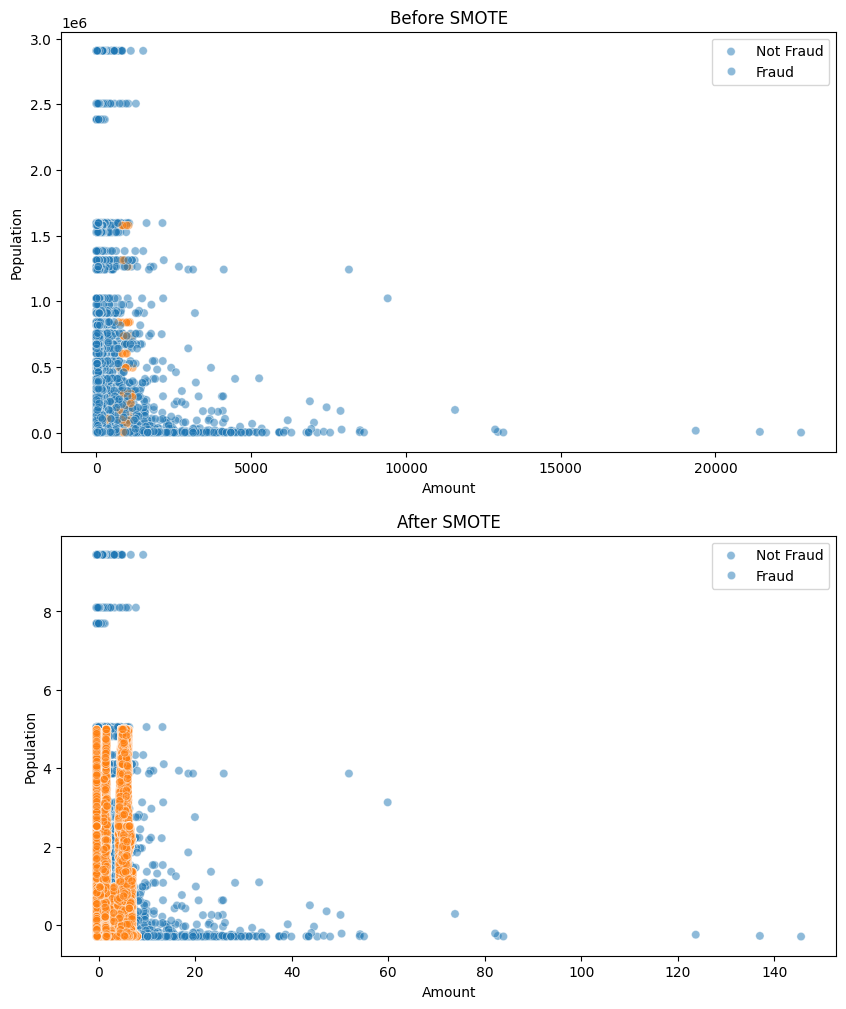

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
sns.scatterplot(
    data=pd.concat([X_train, y_train], axis = 1),
    x='amt',
    y='city_pop',
    hue='is_fraud',
    alpha=0.5,
    ax=ax[0]
)
ax[0].set_title('Before SMOTE')
sns.scatterplot(
    data=pd.concat([X_smote, y_smote], axis = 1),
    x='amt',
    y='city_pop',
    hue='is_fraud',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set_title('After SMOTE')

for a in ax:
    a.set_xlabel('Amount')
    a.set_ylabel('Population')
    a.legend(['Not Fraud', 'Fraud'])
plt.show()

# 7.) We want to compare oversampling, Undersampling and SMOTE across our 3 models (Logistic Regression, Logistic Regression Lasso and Decision Trees).

# Make a dataframe that has a dual index and 9 Rows.
# Calculate: Sensitivity, Specificity, Precision, Recall and F1 score. for out of sample data.
# Notice any patterns across performance for this model. Does one totally out perform the others IE. over/under/smote or does a model perform better DT, Lasso, LR?
# Choose what you think is the best model and why. test on Holdout

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

In [32]:
model_configs = {
    'log': LogisticRegression(),
    'lasso': LogisticRegression(
        penalty = 'l1', C = 0.5, solver = 'liblinear'
    ),
    'tree': DecisionTreeClassifier()
}

balancing_configs = {
    'over': RandomOverSampler(),
    'under': RandomUnderSampler(),
    'smote': SMOTE()
}

In [33]:
trained_models = {}
scores_for_df = {}

In [34]:
for i,j in balancing_configs.items():
    for k,l in model_configs.items():
        pipe = Pipeline(
            steps=[
                ('scaler', StandardScaler()),
                ('balancer', j),
                ('model', l)
            ]
        )
        pipe.fit(X_train, y_train)
        trained_models[(i,k)] = pipe
        # Compute precision, recall, f1 score and store them in a dictionary
        y_pred = pipe.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sensitivity = cm[1,1] /( cm[1,0] + cm[1,1])
        specificity = cm[0,0] /( cm[0,0] + cm[0,1])
        accuracy = pipe.score(X_test, y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        scores_for_df[(i,k)] = {
            'precision': precision,
            'recall': recall,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'accuracy': accuracy,
            'f1': f1,
        }

In [35]:
pd.DataFrame(scores_for_df).T

precision    recall  sensitivity  specificity  accuracy        f1
over  log     0.029611  0.701639     0.701639     0.915560  0.914777  0.056824
      lasso   0.029355  0.701639     0.701639     0.914801  0.914021  0.056353
      tree    0.529197  0.475410     0.475410     0.998447  0.996533  0.500864
under log     0.023668  0.704918     0.704918     0.893213  0.892524  0.045798
      lasso   0.031471  0.701639     0.701639     0.920701  0.919900  0.060239
      tree    0.066293  0.931148     0.931148     0.951838  0.951762  0.123774
smote log     0.027803  0.701639     0.701639     0.909901  0.909139  0.053487
      lasso   0.027659  0.701639     0.701639     0.909419  0.908659  0.053221
      tree    0.260483  0.672131     0.672131     0.992992  0.991818  0.375458

In term of balancing method, the Smote method performs better, specially in the decision tree model, evaluating the sensitivity. In terms of models, the decision tree outperforms the logistic regression and the lasso logistic regression, but is less robust given that it happens only with the random undersampler balancing method. 